In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

**Mengambil Dataset yang telah di upload:**

In [2]:
data_train = pd.read_csv('powerconsumption.csv')
data_train.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


**Mengecek nilai kosong pada dataset:**

In [3]:
data_train.isnull().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

**Menghitung total isi dataset:**

In [4]:
len(data_train)

52416

**Membagi data time series:**


In [5]:
dates = data_train['Datetime'].values
power_consumption = data_train['PowerConsumption_Zone1'].values

**Visualisasi dataset time series:**

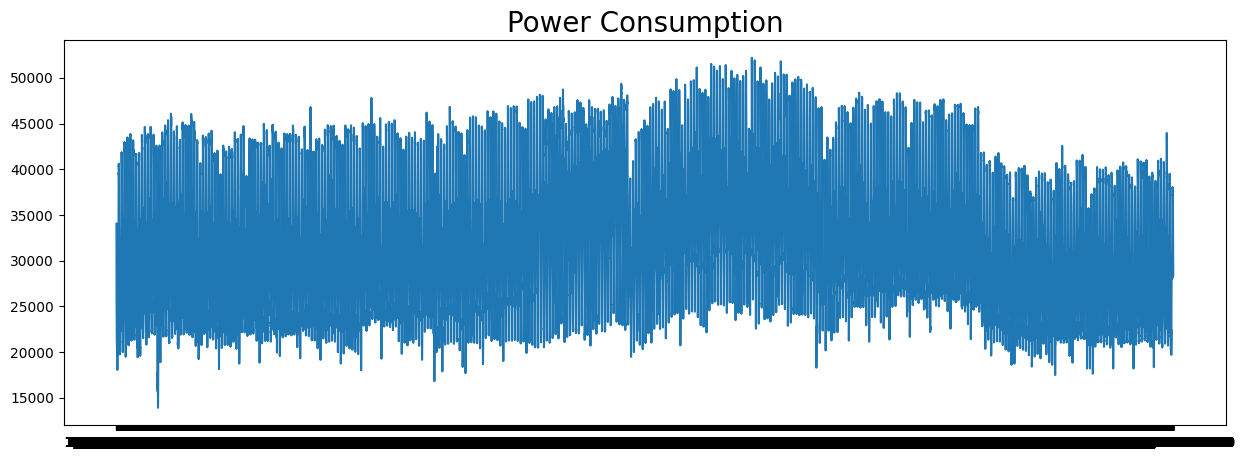

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dates, power_consumption)
plt.title('Power Consumption', fontsize=20);

**Normalisasi dataset:**

In [7]:
scaler = MinMaxScaler()
scaled_power_consumption = scaler.fit_transform(np.array(power_consumption).reshape(-1, 1))

print(scaled_power_consumption)

[[0.52625123]
 [0.41554498]
 [0.39762262]
 ...
 [0.40970272]
 [0.3931869 ]
 [0.37730631]]


**Menentukan 10% Threshold MAE dari dataset:**

In [8]:
threshold_mae = (scaled_power_consumption.max() - scaled_power_consumption.min()) * 10/100
threshold_mae

0.09999999999999998

**Function untuk mengubah format dataset:**

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

**Membagi data training dan validation:**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dates, scaled_power_consumption, test_size=0.2, shuffle=False)

**Mengubah format dataset agar dapat diterima function windowed_dataset:**

In [11]:
y_train = tf.squeeze(y_train, axis=-1)
y_test = tf.squeeze(y_test, axis=-1)

**Mengubah format dataset agar dapat diterima model:**

In [19]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=1000)

**Membuat model:**

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

**Melatih Model:**

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae')<threshold_mae):
      print('\nMae dibawah 10% tercapai')
      self.model.stop_training = True
callbacks = myCallback()


history = model.fit(train_set,
                    epochs=100,
                    validation_data=validation_set,
                    callbacks=callbacks
                    )

Epoch 1/100
419/419 [==============================] - 70s 156ms/step - loss: 0.0670 - mae: 0.3159 - val_loss: 0.0130 - val_mae: 0.1338
Epoch 2/100
419/419 [==============================] - 65s 155ms/step - loss: 0.0180 - mae: 0.1562 - val_loss: 0.0123 - val_mae: 0.1308
Epoch 3/100
419/419 [==============================] - 64s 153ms/step - loss: 0.0143 - mae: 0.1403 - val_loss: 0.0144 - val_mae: 0.1427
Epoch 4/100
419/419 [==============================] - 61s 145ms/step - loss: 0.0140 - mae: 0.1386 - val_loss: 0.0149 - val_mae: 0.1455
Epoch 5/100
419/419 [==============================] - 62s 147ms/step - loss: 0.0138 - mae: 0.1376 - val_loss: 0.0149 - val_mae: 0.1454
Epoch 6/100
419/419 [==============================] - 65s 154ms/step - loss: 0.0137 - mae: 0.1367 - val_loss: 0.0147 - val_mae: 0.1444
Epoch 7/100
419/419 [==============================] - 65s 154ms/step - loss: 0.0135 - mae: 0.1357 - val_loss: 0.0145 - val_mae: 0.1434
Epoch 8/100
419/419 [===========================

**Visualisasi Loss dan MAE:**

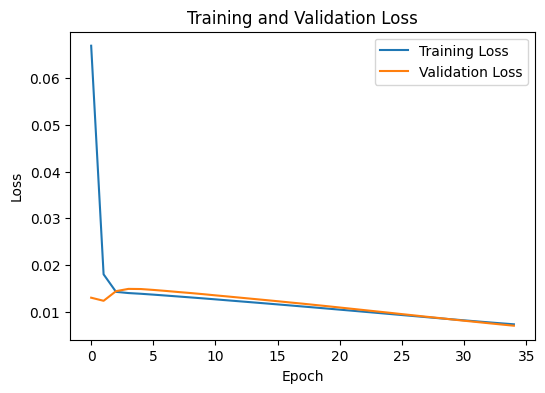

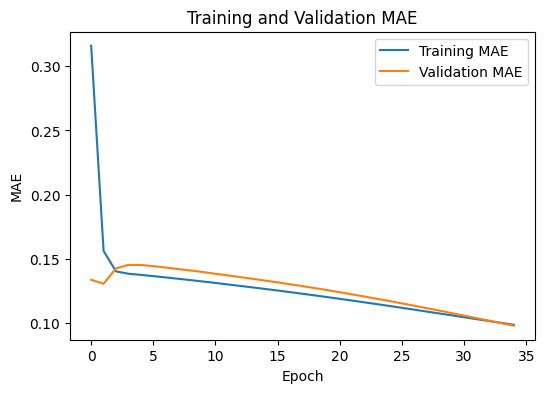

In [23]:
loss = history.history['loss']
mae = history.history['mae']
val_loss = history.history['val_loss']
val_mae = history.history['val_mae']

plt.figure(figsize=(6, 4))
plt.subplot(1, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.subplot(1, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()